从筛选好的公司中将公司分为4（5）类
- 在高点
- 在低点
- 在上升过程中
- 在下降过程中
- （无法判断，舍弃）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.signal as signal
from random import sample

In [23]:
from scipy.stats.mstats import winsorize

## 重新筛选公司
- 按极点相差的绝对数值，比如相差2
- 比例，相差2的比例超过0.5

In [2]:
machineDiff = pd.read_excel("/Users/zch/Desktop/internship/Jan15/machineROEDiff.xlsx")

In [3]:
def getCompanyByCode(code, data):
    '''
    code, data; company, df; y, series
    '''
    company = data[data["code"].str.contains(code)]
    y = company.iloc[0, 2:]
    # 进行缩尾处理
    # TODO
    return company, y

def getYRolling(y, n=8, gaussian=True, center=True):
    '''
    获取滚动值，y series roe数据
    '''
    if gaussian:
        yRolling = y.rolling(n, win_type="gaussian", center=center).mean(std=np.std(y,ddof=1))
    else:
        yRolling = y.rolling(n, center=center).mean()
    return yRolling

def getExtreme(yRolling, order=3):
    '''
    返回极值下标
    '''
    y = np.array(yRolling)
    maximum = signal.argrelextrema(y, np.greater_equal, order=order)[0]
    minimum = signal.argrelextrema(y, np.less_equal, order=order)[0]
    return maximum, minimum

def drawROEandExtreme(maxs, mins, y, yRolling, company, minBool=True, maxBool=True, roeBool=True):
    '''
    绘制roe和极点, company, df 只有一行
    '''
    fig, axs = plt.subplots(figsize=(12, 5))
    x = [datetime.strptime(d, '%Y-%m').date() for d in company.columns[2:]]
    # y = company.iloc[0, 2:]
    if roeBool:
        axs.plot(x, y, label="roe")
    axs.plot(x, yRolling, label="roll")
    xMax = [datetime.strptime(d, '%Y-%m').date() for d in maxs.index]
    xMin = [datetime.strptime(d, '%Y-%m').date() for d in mins.index]
    axs.scatter(xMax, maxs, label="max", c='r')
    axs.scatter(xMin, mins, label="min", c='g')
    if maxBool:
        for i, tempX in enumerate(xMax):
            axs.annotate(str(tempX)[:-3], xy=(tempX, maxs[i]+0.1), c="r")
    if minBool:
        for i, tempX in enumerate(xMin):
            axs.annotate(str(tempX)[:-3], xy=(tempX, mins[i]-0.1), c="g")
    axs.set_title(company.iloc[0, 0])  # code
    fig.legend()

def pickOne(data):
    one = randint(0, len(data)-1)
    companyCode = data.iloc[one, 0]
    companyName = data.iloc[one, 1]
    return companyCode, companyName

def showOne(code, data, n=8, gaussian=True, center=True, order=3, maxBool=True, minBool=True, roeBool=True):
    company, y = getCompanyByCode(code, data)
    yRolling = getYRolling(y, n=n, gaussian=gaussian, center=center)
    maximum, minimum = getExtreme(yRolling, order)
    maxs, mins = yRolling[maximum], yRolling[minimum]
    drawROEandExtreme(maxs, mins, y, yRolling, company, maxBool, minBool, roeBool)

In [313]:
def isGoodByAbsDiff(maxs, mins, absDiff=2, threshold=0.3):
    '''
    Description:
    根据极大极小值的绝对差值来判定
    ---
    Params:
    maxs, Series, maximum values, index-datetime
    mins, Series, minimum values, index-datetime
    absDiff, float, default 2, threshold for difference between adjacent maximum and minimum value
    threshold, float, default 0.4, threshold for the proportion exceeding the absDiff
    ---
    Returns:
    bool, True means good company
    '''
    minMax = pd.concat([maxs, mins]).sort_index()
    minMaxDiff = np.abs(minMax.diff(1))  # 相邻极值点的差值
    # print(minMaxDiff)
    return (minMaxDiff>absDiff).sum() > threshold*(len(minMaxDiff)-1)

# 中间中断的公司
def isContinuous(x):
    '''
    Description:
    筛选出中断的公司，中断期不超过1
    ---
    Params:
    x, for df.apply(), a row Series
    ---
    Returns:
    bool, True 表示连续, False means discontinuity
    '''
    it = iter(x)
    # 确保有元素且不全为nan
    while isinstance(next(it), str):
        pass
    while np.isnan(next(it)):
            pass 
    count = 0
    while True:
        try:
            temp = next(it)
            if np.isnan(temp):
                count+=1
                if count>1:
                    return False
        except StopIteration:
            return True

In [11]:
# test 600528.SH 中铁工业
company, y = getCompanyByCode("600031", machineDiff)  # 三一重工
yRolling = getYRolling(y)
# print(len(yRolling))
# print(yRolling.count())
# for i, v in yRolling.iteritems():
#     print(i, v)
# maxIdx, minIdx = getExtreme(yRolling, order=3)
# maxs, mins = yRolling[maxIdx], yRolling[minIdx]
# isGoodByAbsDiff(maxs, mins, absDiff=1.7, threshold=0.3)

In [307]:
def selectCompanyByAbsDiff(diff, absDiff=1.7, threshold=0.3, order=3, minNum=40, minExtreme=4, winsorize=True):
    '''
    Description:
    根据绝对差值选择公司并导出
    ---
    Params:
    diff, DataFrame, one difference data
    absDiff, float default 1.7
    threshold, float default 0.3, proportion threshold
    order, int default 3, order for guassian filter
    minNum, int default 40, minimum row number for required data
    minExtreme, int default 4, minimum tolerance for existing extreme points
    winsorize, bool default True, winsorize to (0.05, 0.95)
    ---
    Returns:
    goodCodes, list, codes for good companies
    temp, df, after winsorized and so on
    '''
    temp = diff.copy()
    # drop year with all being NaN
    temp.dropna(axis=1, how="all", inplace=True)
    # 至少有minNum个季度
    temp = temp[temp.count(axis=1)>minNum]
    # ROE 数据连续
    temp = temp[temp.apply(lambda x:isContinuous(x), axis=1)]
    # 缩尾
    if winsorize:
        temp.iloc[:,2:] = temp.iloc[:,2:].apply(lambda x: np.clip(x, np.nanquantile(x, 0.05), np.nanquantile(x, 0.95)),axis=1)
    codes = temp["code"].values
    goodCodes = []
    for code in codes:
        company, y = getCompanyByCode(code, temp)
        yRolling = getYRolling(y)
        # if yRolling.count()<minNum:
        #     continue
        maxIdx, minIdx = getExtreme(yRolling, order=order)
        if len(maxIdx)+len(minIdx)<minExtreme:
            continue
        maxs, mins = yRolling[maxIdx], yRolling[minIdx]
        if isGoodByAbsDiff(maxs, mins, absDiff=absDiff, threshold=threshold):
            goodCodes.append(code)
    return goodCodes, temp

In [323]:
# test
goodCodes, temp = selectCompanyByAbsDiff(machineDiff, absDiff=1.7, threshold=0.3, order=3, minNum=40, minExtreme=4, winsorize=True)
len(goodCodes)

58

600302.SH
300092.SZ
600481.SH


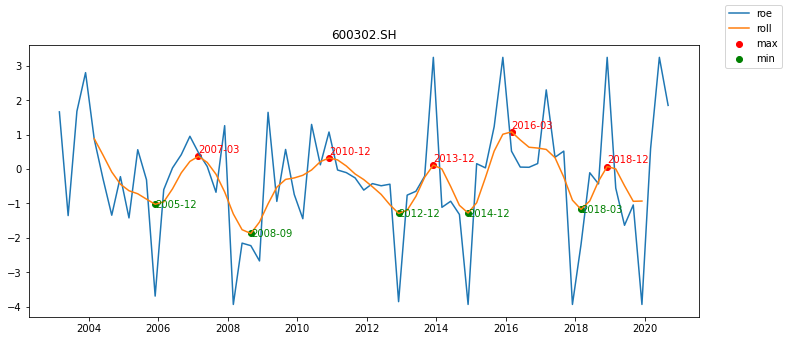

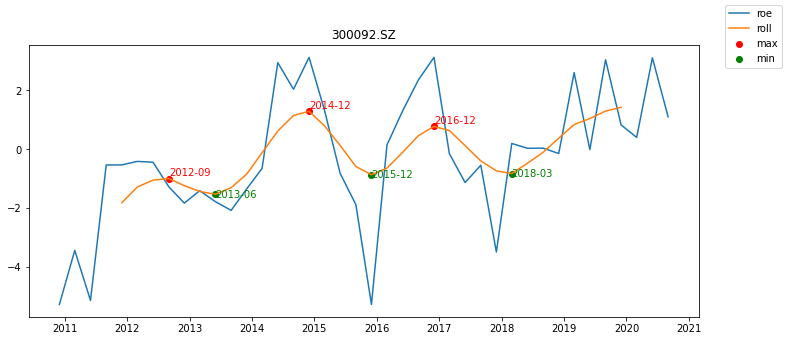

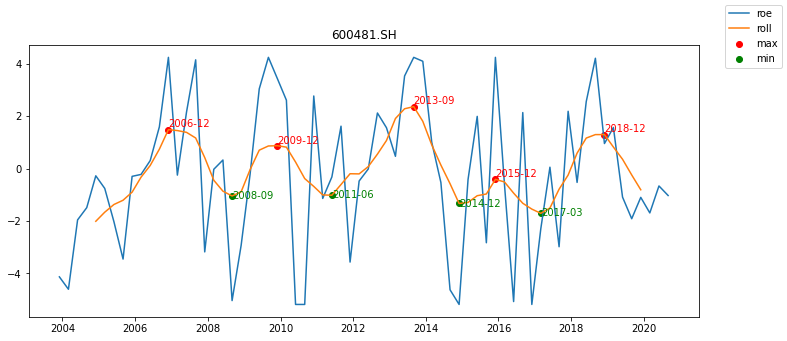

In [320]:
# test
for code in sample(goodCodes, k=3):
    print(code)
    showOne(code, temp, roeBool=True)
# 300084.SZ
# showOne("300084", temp)
# showOne("300084", machineDiff)

## 处理异常值
- [x] winsorize
- [x] roe中间中断的公司删除

In [300]:
temp = machineDiff.copy()

In [301]:
temp.dropna(axis=1, how="all", inplace=True)
    # 至少有minNum个季度
temp = temp[temp.count(axis=1)>40]

In [302]:
tt = temp.apply(lambda x:isContinuous(x), axis=1)
len(tt)

119

In [303]:
count = 0
for i, v in tt.iteritems():
    if v:
        count+=1
count

65

## 公司分类
- 高点
- 低点
- 上升
- 下降

In [316]:
for code in goodCodes:
    print(temp[temp["code"]==code].iloc[0,:2].values)

['000039.SZ' '中集集团']
['000157.SZ' '中联重科']
['000425.SZ' '徐工机械']
['000528.SZ' '柳工']
['000584.SZ' '哈工智能']
['000680.SZ' '山推股份']
['000821.SZ' '京山轻机']
['000852.SZ' '石化机械']
['000856.SZ' '冀东装备']
['000976.SZ' '华铁股份']
['002006.SZ' '精功科技']
['002009.SZ' '天奇股份']
['002073.SZ' '软控股份']
['002097.SZ' '山河智能']
['002132.SZ' '恒星科技']
['002150.SZ' '通润装备']
['002158.SZ' '汉钟精机']
['002164.SZ' '宁波东力']
['002248.SZ' '华东数控']
['002272.SZ' '川润股份']
['002278.SZ' '神开股份']
['002337.SZ' '赛象科技']
['002366.SZ' '台海核电']
['002430.SZ' '杭氧股份']
['002438.SZ' '江苏神通']
['002490.SZ' '山东墨龙']
['002520.SZ' '日发精机']
['002526.SZ' '山东矿机']
['300024.SZ' '机器人']
['300080.SZ' '易成新能']
['300084.SZ' '海默科技']
['300091.SZ' '金通灵']
['300092.SZ' '科新机电']
['300099.SZ' '精准信息']
['300126.SZ' '锐奇股份']
['300161.SZ' '华中数控']
['600031.SH' '三一重工']
['600169.SH' '太原重工']
['600218.SH' '全柴动力']
['600302.SH' '标准股份']
['600320.SH' '振华重工']
['600375.SH' '汉马科技']
['600388.SH' '龙净环保']
['600481.SH' '双良节能']
['600499.SH' '科达制造']
['600501.SH' '航天晨光']
['600520.SH' '文一科技']
['600528.SH' '中铁工

In [325]:
tt = temp[temp["code"].apply(lambda x: x in goodCodes)]

In [326]:
tt.to_excel("temp58Good.xlsx", index=False)